In [11]:
from datasets import load_dataset
from transformers import pipeline
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

In [3]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Sentences we want to encode. Example:
sentence = ['This framework generates embeddings for each input sentence']

# Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)
embedding.shape

(1, 384)

# Baseline

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

data = pd.read_csv("baseline.csv")  
df = data.drop(columns= ["Unnamed: 0"])
print(df.shape)
df.head()

(6000, 2)


,text,label
0,"If bullying is based on a person’s race, color...",0
1,"If you know why you want to leave home, choosi...",0
2,Set a date. Invite friends and family. Decide ...,0
3,"As you sit down with your thesis draft, preten...",0
4,The factors are the numbers that multiply to c...,0


In [15]:
sentences = df['text']
labels = df['label'] # 1: abstract, 0: concrete

sentence_embeddings = model.encode(sentences, convert_to_tensor=True)

data['embeddings'] = sentence_embeddings.tolist()

X_train, X_test, y_train, y_test = train_test_split(data['embeddings'], labels, test_size=0.2, random_state=42)

X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

y_train = np.array(y_train)
y_test = np.array(y_test)

In [19]:
X_train.shape, y_train.shape

((4800, 384), (4800,))

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [26]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(probability=True),
    #"K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

from sklearn.metrics import f1_score, roc_auc_score

results = {name: {} for name in classifiers.keys()}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results[name]['Accuracy'] = accuracy_score(y_test, y_pred)
    results[name]['F1 Score'] = f1_score(y_test, y_pred)
    results[name]['ROC AUC'] = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f"{name} - Accuracy: {results[name]['Accuracy']:.4f}, F1 Score: {results[name]['F1 Score']:.4f}, ROC AUC: {results[name]['ROC AUC']:.4f}")

best_by_f1 = max(results, key=lambda x: results[x]['F1 Score'])
print(f"Best classifier by F1 Score is {best_by_f1} with an F1 Score of {results[best_by_f1]['F1 Score']:.4f}")

Logistic Regression - Accuracy: 0.8033, F1 Score: 0.7915, ROC AUC: 0.8835
Support Vector Machine - Accuracy: 0.8183, F1 Score: 0.8137, ROC AUC: 0.9029
Decision Tree - Accuracy: 0.6667, F1 Score: 0.6587, ROC AUC: 0.6665
Random Forest - Accuracy: 0.7550, F1 Score: 0.7461, ROC AUC: 0.8488
Gradient Boosting - Accuracy: 0.7725, F1 Score: 0.7569, ROC AUC: 0.8636
Naive Bayes - Accuracy: 0.6292, F1 Score: 0.5137, ROC AUC: 0.7121
Neural Network - Accuracy: 0.8108, F1 Score: 0.8094, ROC AUC: 0.9004
Best classifier by F1 Score is Support Vector Machine with an F1 Score of 0.8137


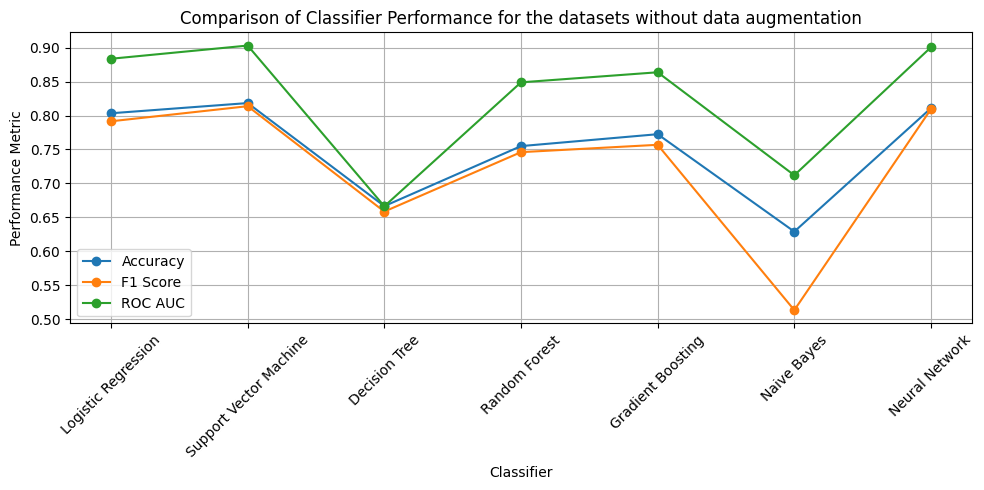

In [35]:
classifiers = [
    "Logistic Regression", "Support Vector Machine", "Decision Tree",
    "Random Forest", "Gradient Boosting", "Naive Bayes", "Neural Network"
]

# Performance metrics
accuracy = [0.8033, 0.8183, 0.6667, 0.7550, 0.7725, 0.6292, 0.8108]
f1_scores = [0.7915, 0.8137, 0.6587, 0.7461, 0.7569, 0.5137, 0.8094]
roc_auc = [0.8835, 0.9029, 0.6665, 0.8488, 0.8636, 0.7121, 0.9004]

# Creating the plot
plt.figure(figsize=(10, 5))
plt.plot(classifiers, accuracy, label='Accuracy', marker='o')
plt.plot(classifiers, f1_scores, label='F1 Score', marker='o')
plt.plot(classifiers, roc_auc, label='ROC AUC', marker='o')
plt.title('Comparison of Classifier Performance for the datasets without data augmentation')
plt.xlabel('Classifier')
plt.ylabel('Performance Metric')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Approach 1: mixup_augmented

In [31]:
data = pd.read_csv("mixup_augmented.csv")  
df = data.drop(columns= ["Unnamed: 0"])
print(df.shape)
df.head()

(11077, 2)


,text,label
0,Scott Brown and Elizabeth Warren are rivals i...,1.0
1,video on vision islam ' s facebook page shows ...,0.0
2,XXVII. LITERARY LESSONS.\n\n\n ...,0.0
3,"It was the White Rabbit, trotting slowly back ...",0.0
4,"Type ""cleanmgr"" into the Run text field.",1.0


In [29]:
sentences = df['text']
labels = df['label'] # 1: abstract, 0: concrete

sentence_embeddings = model.encode(sentences, convert_to_tensor=True)

data['embeddings'] = sentence_embeddings.tolist()

X_train, X_test, y_train, y_test = train_test_split(data['embeddings'], labels, test_size=0.2, random_state=42)

X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

y_train = np.array(y_train)
y_test = np.array(y_test)

In [30]:
X_train.shape, y_train.shape

((8861, 384), (8861,))

In [33]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(probability=True),
    #"K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

from sklearn.metrics import f1_score, roc_auc_score

results = {name: {} for name in classifiers.keys()}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results[name]['Accuracy'] = accuracy_score(y_test, y_pred)
    results[name]['F1 Score'] = f1_score(y_test, y_pred)
    results[name]['ROC AUC'] = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f"{name} - Accuracy: {results[name]['Accuracy']:.4f}, F1 Score: {results[name]['F1 Score']:.4f}, ROC AUC: {results[name]['ROC AUC']:.4f}")

best_by_f1 = max(results, key=lambda x: results[x]['F1 Score'])
print(f"Best classifier by F1 Score is {best_by_f1} with an F1 Score of {results[best_by_f1]['F1 Score']:.4f}")

Logistic Regression - Accuracy: 0.8335, F1 Score: 0.8118, ROC AUC: 0.9070
Support Vector Machine - Accuracy: 0.8921, F1 Score: 0.8744, ROC AUC: 0.9576
Decision Tree - Accuracy: 0.8962, F1 Score: 0.8828, ROC AUC: 0.8928
Random Forest - Accuracy: 0.8967, F1 Score: 0.8776, ROC AUC: 0.9842
Gradient Boosting - Accuracy: 0.8443, F1 Score: 0.8185, ROC AUC: 0.9210
Naive Bayes - Accuracy: 0.6724, F1 Score: 0.5530, ROC AUC: 0.7322
Neural Network - Accuracy: 0.9251, F1 Score: 0.9156, ROC AUC: 0.9720
Best classifier by F1 Score is Neural Network with an F1 Score of 0.9156


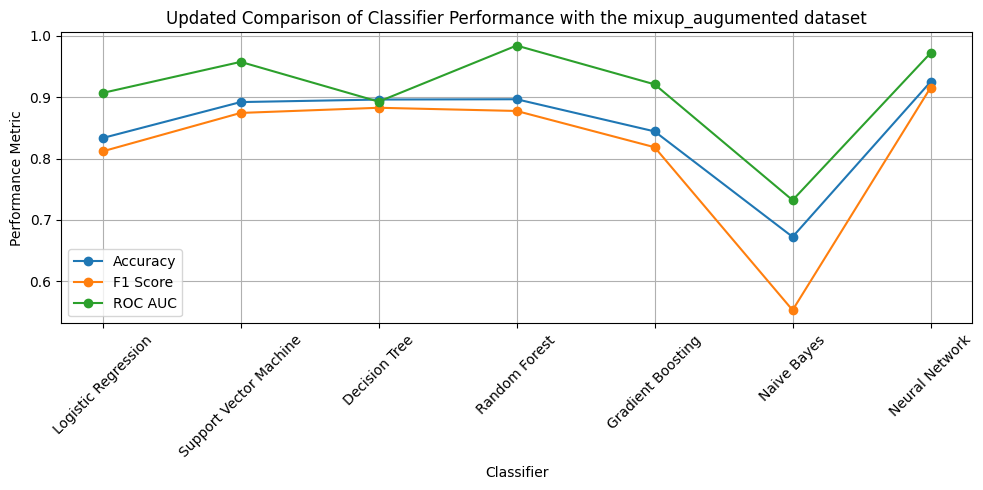

In [36]:
# Updated performance metrics
accuracy_updated = [0.8335, 0.8921, 0.8962, 0.8967, 0.8443, 0.6724, 0.9251]
f1_scores_updated = [0.8118, 0.8744, 0.8828, 0.8776, 0.8185, 0.5530, 0.9156]
roc_auc_updated = [0.9070, 0.9576, 0.8928, 0.9842, 0.9210, 0.7322, 0.9720]

# Creating the updated plot
plt.figure(figsize=(10, 5))
plt.plot(classifiers, accuracy_updated, label='Accuracy', marker='o')
plt.plot(classifiers, f1_scores_updated, label='F1 Score', marker='o')
plt.plot(classifiers, roc_auc_updated, label='ROC AUC', marker='o')
plt.title('Updated Comparison of Classifier Performance with the mixup_augumented dataset')
plt.xlabel('Classifier')
plt.ylabel('Performance Metric')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Approach 2: paraphrased augmented

In [6]:
data = pd.read_csv("paraphrased_augmented_dataset.csv")  
df = data.drop(columns= ["Unnamed: 0"])
print(df.shape)
df.head()

(10500, 2)


,text,label
0,"If bullying is based on a person’s race, color...",0
1,"If you know why you want to leave home, choosi...",0
2,Set a date. Invite friends and family. Decide ...,0
3,"As you sit down with your thesis draft, preten...",0
4,The factors are the numbers that multiply to c...,0


In [7]:
sentences = df['text']
labels = df['label'] # 1: abstract, 0: concrete

sentence_embeddings = model.encode(sentences, convert_to_tensor=True)

data['embeddings'] = sentence_embeddings.tolist()

X_train, X_test, y_train, y_test = train_test_split(data['embeddings'], labels, test_size=0.2, random_state=42)

X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

y_train = np.array(y_train)
y_test = np.array(y_test)

In [8]:
X_train.shape, y_train.shape

((8400, 384), (8400,))

In [9]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(probability=True),
    #"K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

from sklearn.metrics import f1_score, roc_auc_score

results = {name: {} for name in classifiers.keys()}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results[name]['Accuracy'] = accuracy_score(y_test, y_pred)
    results[name]['F1 Score'] = f1_score(y_test, y_pred)
    results[name]['ROC AUC'] = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f"{name} - Accuracy: {results[name]['Accuracy']:.4f}, F1 Score: {results[name]['F1 Score']:.4f}, ROC AUC: {results[name]['ROC AUC']:.4f}")

best_by_f1 = max(results, key=lambda x: results[x]['F1 Score'])
print(f"Best classifier by F1 Score is {best_by_f1} with an F1 Score of {results[best_by_f1]['F1 Score']:.4f}")

Logistic Regression - Accuracy: 0.8433, F1 Score: 0.8604, ROC AUC: 0.9151
Support Vector Machine - Accuracy: 0.8924, F1 Score: 0.9081, ROC AUC: 0.9525
Decision Tree - Accuracy: 0.7771, F1 Score: 0.7997, ROC AUC: 0.7741
Random Forest - Accuracy: 0.8838, F1 Score: 0.9007, ROC AUC: 0.9577
Gradient Boosting - Accuracy: 0.8295, F1 Score: 0.8480, ROC AUC: 0.9076
Naive Bayes - Accuracy: 0.5967, F1 Score: 0.5424, ROC AUC: 0.7392
Neural Network - Accuracy: 0.9038, F1 Score: 0.9152, ROC AUC: 0.9632
Best classifier by F1 Score is Neural Network with an F1 Score of 0.9152


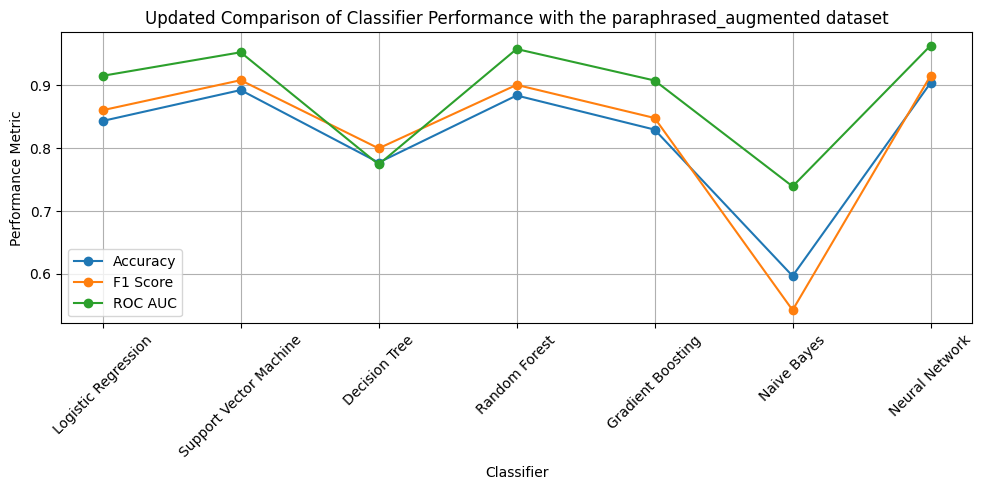

In [15]:
accuracy_third = [0.8433, 0.8924, 0.7771, 0.8838, 0.8295, 0.5967, 0.9038]
f1_scores_third = [0.8604, 0.9081, 0.7997, 0.9007, 0.8480, 0.5424, 0.9152]
roc_auc_third = [0.9151, 0.9525, 0.7741, 0.9577, 0.9076, 0.7392, 0.9632]
classifiers = [
    "Logistic Regression", "Support Vector Machine", "Decision Tree",
    "Random Forest", "Gradient Boosting", "Naive Bayes", "Neural Network"
]
# Creating the updated plot
plt.figure(figsize=(10, 5))
plt.plot(classifiers, accuracy_third, label='Accuracy', marker='o')
plt.plot(classifiers, f1_scores_third, label='F1 Score', marker='o')
plt.plot(classifiers, roc_auc_third, label='ROC AUC', marker='o')
plt.title('Updated Comparison of Classifier Performance with the paraphrased_augmented dataset')
plt.xlabel('Classifier')
plt.ylabel('Performance Metric')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Comparsion

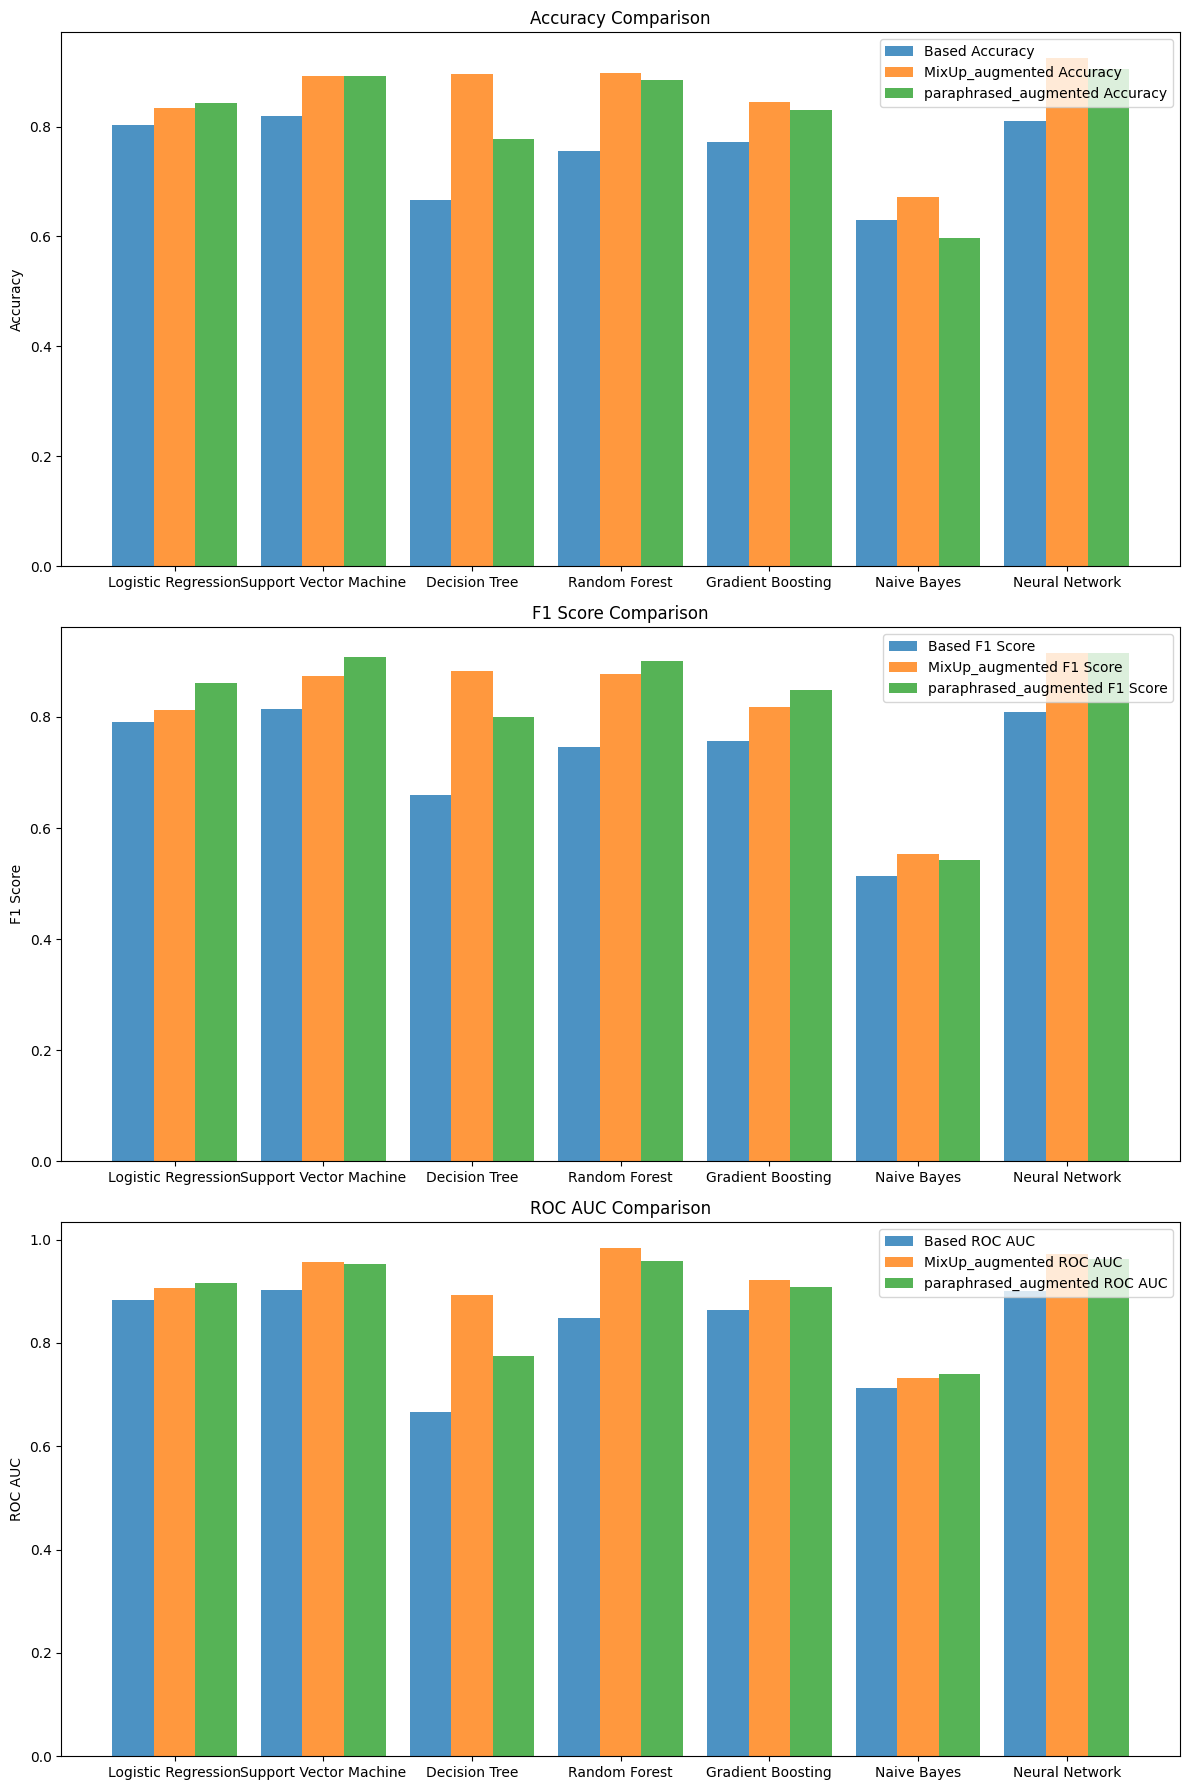

In [16]:
classifiers = [
    "Logistic Regression", "Support Vector Machine", "Decision Tree",
    "Random Forest", "Gradient Boosting", "Naive Bayes", "Neural Network"
]

# Performance metrics for three evaluations
accuracy = [0.8033, 0.8183, 0.6667, 0.7550, 0.7725, 0.6292, 0.8108]
f1_scores = [0.7915, 0.8137, 0.6587, 0.7461, 0.7569, 0.5137, 0.8094]
roc_auc = [0.8835, 0.9029, 0.6665, 0.8488, 0.8636, 0.7121, 0.9004]

accuracy_updated = [0.8335, 0.8921, 0.8962, 0.8967, 0.8443, 0.6724, 0.9251]
f1_scores_updated = [0.8118, 0.8744, 0.8828, 0.8776, 0.8185, 0.5530, 0.9156]
roc_auc_updated = [0.9070, 0.9576, 0.8928, 0.9842, 0.9210, 0.7322, 0.9720]

accuracy_third = [0.8433, 0.8924, 0.7771, 0.8838, 0.8295, 0.5967, 0.9038]
f1_scores_third = [0.8604, 0.9081, 0.7997, 0.9007, 0.8480, 0.5424, 0.9152]
roc_auc_third = [0.9151, 0.9525, 0.7741, 0.9577, 0.9076, 0.7392, 0.9632]

# Creating side-by-side bar charts for three sets of results
fig, ax = plt.subplots(3, 1, figsize=(12, 18), tight_layout=True)

# Bar width
bar_width = 0.28
indices = np.arange(len(classifiers))

# Accuracy bars
ax[0].bar(indices, accuracy, bar_width, label='Based Accuracy', alpha=0.8)
ax[0].bar(indices + bar_width, accuracy_updated, bar_width, label='MixUp_augmented Accuracy', alpha=0.8)
ax[0].bar(indices + 2 * bar_width, accuracy_third, bar_width, label='paraphrased_augmented Accuracy', alpha=0.8)
ax[0].set_title('Accuracy Comparison')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticks(indices + bar_width)
ax[0].set_xticklabels(classifiers)
ax[0].legend()

# F1 Score bars
ax[1].bar(indices, f1_scores, bar_width, label='Based F1 Score', alpha=0.8)
ax[1].bar(indices + bar_width, f1_scores_updated, bar_width, label='MixUp_augmented F1 Score', alpha=0.8)
ax[1].bar(indices + 2 * bar_width, f1_scores_third, bar_width, label='paraphrased_augmented F1 Score', alpha=0.8)
ax[1].set_title('F1 Score Comparison')
ax[1].set_ylabel('F1 Score')
ax[1].set_xticks(indices + bar_width)
ax[1].set_xticklabels(classifiers)
ax[1].legend()

# ROC AUC bars
ax[2].bar(indices, roc_auc, bar_width, label='Based ROC AUC', alpha=0.8)
ax[2].bar(indices + bar_width, roc_auc_updated, bar_width, label='MixUp_augmented ROC AUC', alpha=0.8)
ax[2].bar(indices + 2 * bar_width, roc_auc_third, bar_width, label='paraphrased_augmented ROC AUC', alpha=0.8)
ax[2].set_title('ROC AUC Comparison')
ax[2].set_ylabel('ROC AUC')
ax[2].set_xticks(indices + bar_width)
ax[2].set_xticklabels(classifiers)
ax[2].legend()

plt.show()